<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative_VGG16_14102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project:** Posgraduate Business Intelligence Master PUC-RJ 2021

# **Classification and Prediction of rock images in drilled wells via Learning Methods Supervised by geological classification of images**

# **1. Overview of files**

**geological_similarity/: stores the images of the 6 types of rocks: **   

* andesite/:rock images directory andesite;
*   gneiss/:rock images directory gneiss;
*   marble:rock images directory marble;
*   quartzite:rock images directory quartzite;
*   rhyolite:rock images directory rhyolite
*   schist:drock images directory schist;

    
Este trabalho se concentrará na análise ....

In [59]:
# Import from libraries

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

In [2]:
# Checking Tensorflow and Keras Versions
print(tf.__version__)

# Install Tensorflow
#!pip install tensorflow==2.6.0

# Install Keras
!pip install keras --upgrade

2.6.0


In [3]:
# If necessary, remove the directories

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
#!rm -rf geological_similarity


# **2. Extraction, Transformation and Loading of the Data**

## **2.1. Kaglle Data Collection**

In [4]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.

#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity   

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.': No such file or directory
 80% 27.0M/33.6M [00:00<00:00, 48.6MB/s]
100% 33.6M/33.6M [00:00<00:00, 84.9MB/s]


# **Creating the directory structure**

In [5]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))

andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)


5000
5000
4998
5000
5000
5000


29998

# **Creation of Parameters**

In [6]:
INIT_LR = 1e-3
EPOCHS = 200
BS=24

# **Dataframe Creation**

In [7]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/gneiss/EZE57.jpg,gneiss
1,geological_similarity/marble/9DSXA.jpg,marble
2,geological_similarity/andesite/44B5P.jpg,andesite
3,geological_similarity/quartzite/3USE5.jpg,quartzite
4,geological_similarity/quartzite/GXFLG.jpg,quartzite
...,...,...
29993,geological_similarity/marble/GEI7B.jpg,marble
29994,geological_similarity/gneiss/I1TJ9.jpg,gneiss
29995,geological_similarity/schist/FY35G.jpg,schist
29996,geological_similarity/rhyolite/UL42T.jpg,rhyolite


# **Convert the images to 32 by 32**

In [8]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

# Convert data and labels to NumPy arrays while scaling the pixel
dados = np.array(dados) 
labels = np.array(labels)
labels

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


array(['gneiss', 'marble', 'andesite', ..., 'schist', 'rhyolite',
       'gneiss'], dtype='<U9')

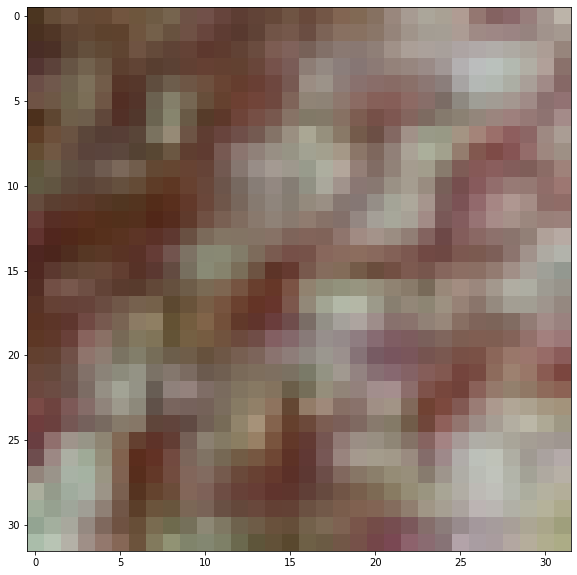

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(dados[labels=='marble'][5])
plt.show()

# **Renaming labels from string format to int**

In [10]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)

[[0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]]


# **Creating the Dataframe on Training, Validation and Testing Data**

In [11]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


# **Normalization**

In [12]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

# **Knowing Image Data**

In [13]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Data cleaning**
1 - Analyzing missing data
2 - Discarding missing data
3 - Imputing data
4 - Adding informative columns

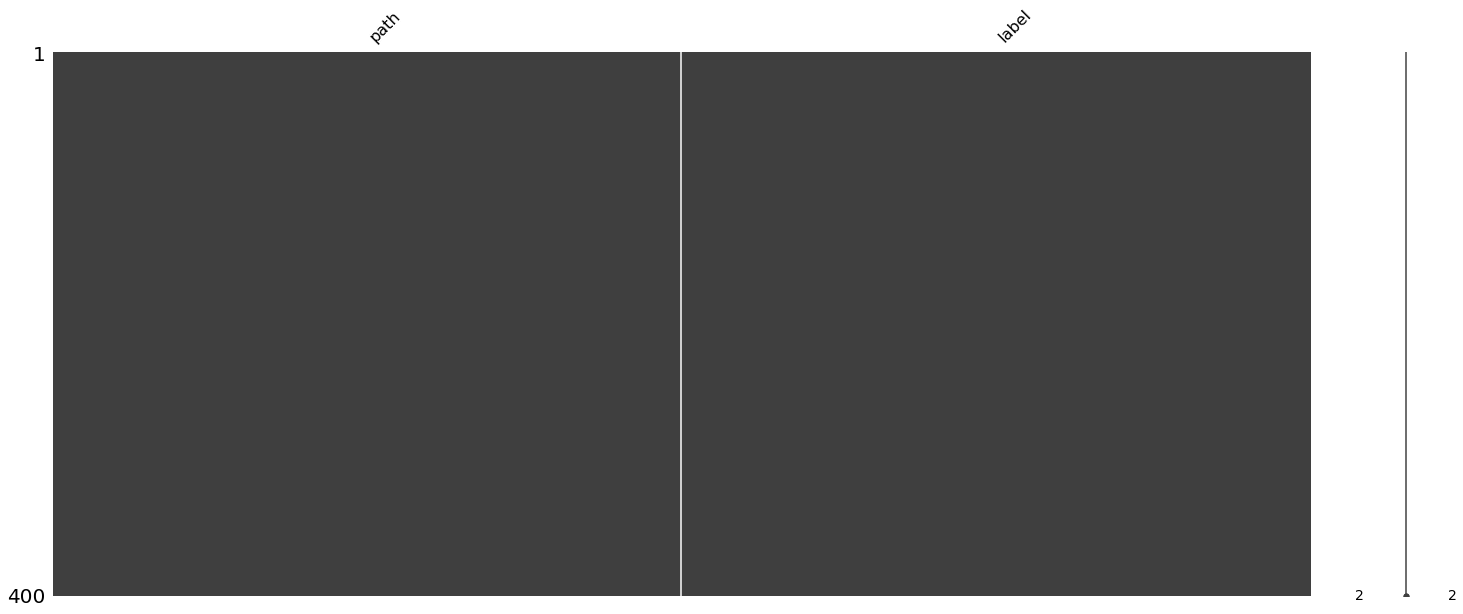

In [14]:
### 1 - Analyzing missing ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

# **Exploring the data**


# **Type: Data Augumentation**

## ** This function will plot the images in a 1 to 5 column grid **

In [15]:
IMG_SHAPE = 32

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [16]:
# Creating the Training and Validation data

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)

In [17]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [18]:
# Test Data

datagen_test = ImageDataGenerator (rescale=1./255, 
                                   #validation_split=0.8,
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation')

Found 29998 validated image filenames belonging to 6 classes.


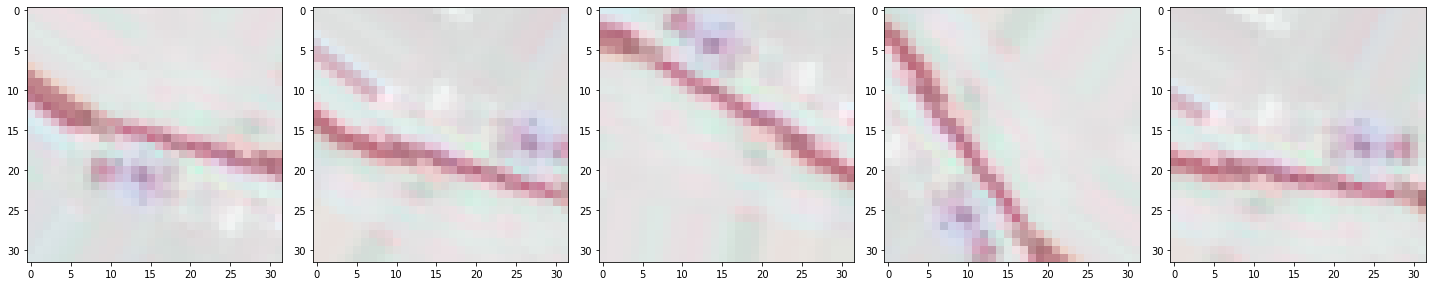

In [19]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [20]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

test_generator.class_indices.keys()

#X_test, y_test = next(test_generator) # não utilizado

dict_keys(['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist'])

# **Perform predictions for classes with the created model**

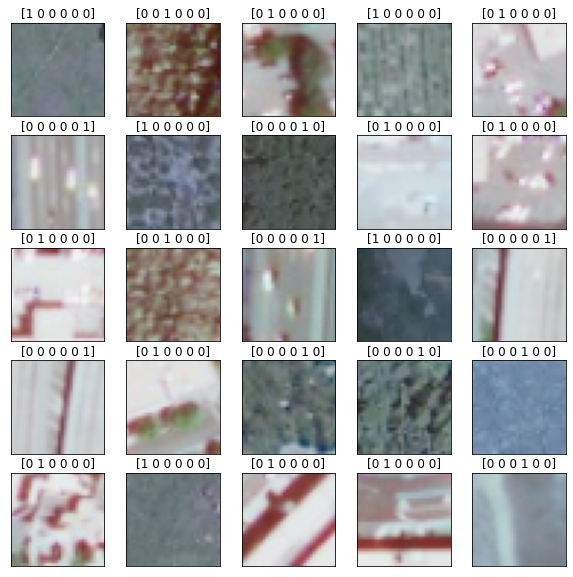

In [30]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    #plt.xlabel(y_train[i])
plt.show()
   

# **the confusion matrix**

[[ 940    0    0   23   24    0]
 [   0 1013    0    2    0   11]
 [   0    0  979    0    0    0]
 [  24    1    0  961    2    1]
 [  11    0    0    0  967    0]
 [   0   32    0    5    2 1002]]


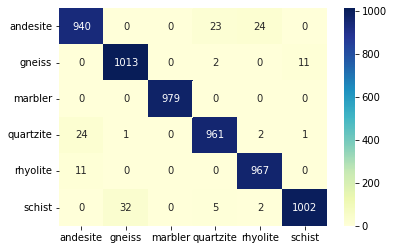

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1),y_pred)

# show the confusion matrix
#print(cm)

cm_matrix = pd.DataFrame(data=cm, columns=['andesite','gneiss','marbler','quartzite','rhyolite','schist'], 
                                 index=['andesite','gneiss','marbler','quartzite','rhyolite','schist'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [62]:
# Calculate the confusion matrix and use it to derive the
# precision, sensitivity and specificitye

total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Show accuracy, sensitivity and specificity
print("acc: {:.4f}".format(acc))

acc: 0.3255


# **Listing the networks actually available in your Keras**

In [63]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **The pre-trained VGG16 Model**
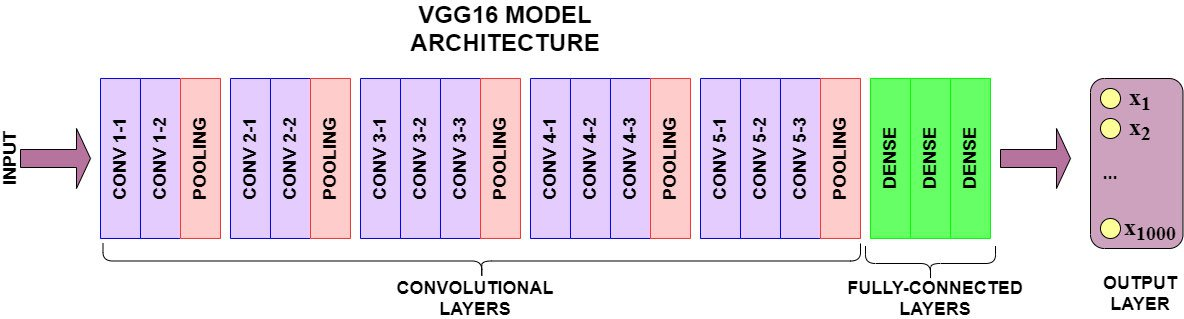

In [64]:
classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 1s 0us/step


In [65]:
# List VGG16 Model Layers
for i,layer in enumerate(classifier.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [66]:
# Marcar as camadas como não treináveis
#for layer in classifier.layers:
   # layer.trainable = False

for layer in classifier.layers[:-2]:
  layer.trainable = False
  print(layer)

# Criar o novo modelo
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = datagen (inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 , offset=-1)
x = scale_layer(inputs)

# Add new layers for classification

x = classifier(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Regularize with dropout
output = Dense(6, activation='softmax')(x)

#flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
#flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
#flat1 = tf.keras.layers.Dropout(0.5)(flat1)
#output = Dense(6, activation='softmax')(flat1)

# The model
modelvgg16 = Model(inputs=inputs, outputs=output)

modelvgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [ ]:
tf.keras.utils.plot_model(modelvgg16, show_shapes=True)

In [68]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [69]:
historyvgg16 = modelvgg16.fit(X_train,y_train,
                    batch_size=BS,
                    epochs=EPOCHS,
                    verbose=1,
                    steps_per_epoch = len(X_train)//BS,
                    callbacks=callbacksvgg16,
                    validation_data=(X_val,y_val),
                    validation_steps = len(X_val) //BS)

Epoch 1/200
749/749 [==============================] - 288s 383ms/step - loss: 0.4876 - accuracy: 0.8311 - val_loss: 0.2188 - val_accuracy: 0.9222
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 2/200
749/749 [==============================] - 289s 386ms/step - loss: 0.2650 - accuracy: 0.9094 - val_loss: 0.1733 - val_accuracy: 0.9372
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 3/200
749/749 [==============================] - 289s 386ms/step - loss: 0.2141 - accuracy: 0.9277 - val_loss: 0.1574 - val_accuracy: 0.9457
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 4/200
749/749 [==============================] - 286s 382ms/step - loss: 0.1931 - accuracy: 0.9355 - val_loss: 0.1396 - val_accuracy: 0.9510
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 5/200
749/749 [==============================] - 289s 386ms/step - loss: 0.1653 - accuracy: 0.9443 - val_loss: 0.1318 - val_accuracy: 0.95

KeyboardInterrupt: ignored

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

In [72]:
# (ref http://stackoverflow.com/q/32239577/395857)

def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_predVGG16[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [73]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

y_predVGG16 = modelvgg16.predict(X_test)

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_accvgg16))

print("-------\n")

print(f"Test accuracy: {test_accvgg16}")
print(f"Test loss: {test_lossvgg16}")

print("-------\n")

#In such a situation, Hamming loss is a good measure of model performance.
#Decrease Hamming loss, better model performance.
# For the above labels, Hamming loss is 0.XXX as calculated below.

hs = hamming_score(y_test, y_predVGG16)
print(f"Hamming loss: {hs}")
print("-------\n")

188/188 [==============================] - 66s 349ms/step - loss: 0.0936 - accuracy: 0.9705
validation_accuracy: 0.9704999923706055
-------

Test accuracy: 0.9704999923706055
Test loss: 0.09360109269618988
-------

Hamming loss: 0.16666666666666666
-------



# **Predições Modelo pre treinado VGG16**

In [ ]:
y_predVGG16 = modelvgg16.predict(X_test)
print("Prediction_accuracy: " + str(y_predVGG16))

In [ ]:
y_predVGG16[300]

In [ ]:
print(np.argmax(y_predVGG16[300]))  #Class 1

In [ ]:
# prediction is correct - Class 1, as shown below:
plt.figure()
plt.imshow(X_train[300])
plt.xlabel(y_test[300])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
print("[INFO] evaluating network...")
y_predVGG16 = modelvgg16.predict(X_test,batch_size=BS)

y_predVGG16 = np.argmax(y_predVGG16, axis=1)

print(classification_report(y_test.argmax(axis=1), y_predVGG16,
                            target_names=lb))

# **Matriz de Confusão**

In [ ]:
from sklearn.metrics import confusion_matrix

cmvgg16 = confusion_matrix(y_test.argmax(axis=1),y_predVGG16)

# show the confusion matrix
print(cmvgg16)

In [ ]:
# Calcule a matriz de confusão e use-a para derivar o
# precisão, sensibilidade e especificidade

total = sum(sum(cmvgg16))
acc = (cmvgg16[0, 0] + cmvgg16[1, 1]) / total
sensitivity = cmvgg16[0, 0] / (cmvgg16[0, 0] + cmvgg16[0, 1])
specificity = cmvgg16[1, 1] / (cmvgg16[1, 0] + cmvgg16[1, 1])

# Mostrar a precisão, sensibilidade e especificidade
print("acc: {:.4f}".format(acc))

# **Confusion matrix with heat map**

In [ ]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

scratch_preds = model.predict(test_generator)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

vgg_preds = modelvgg16.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names1 = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names1, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names1, 
        yticklabels=class_names1,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names1, ax1, title="Custom ")    
plot_heatmap(true_classes, vgg_pred_classes, class_names1, ax2, title="Transfer Learning (VGG16)")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names1, ax3, title="Transfer Learning (VGG16) with Fine-Tuning") 

In [ ]:
#Get the predictions for the test data
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Prediction Class = {predicted_classes[i]}\n   Original Class = {y_test[i]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# **Comparação: modelo Criado vs  modelo pre treinado VGG16**

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','Modelo pre treinado VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()